<a href="https://colab.research.google.com/github/bmeyboom/robot_cnn_trainer/blob/main/cnn_trainer_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

General Notes:
- check that data with no driving labels is not included in training
- figure out how many of each type of command we have (turn right, left, straight), and make sure we use equal amounts of each
- need ~2000 images!! Miti said train to just complete outer loop, and then separately inner loop
- Check images and associated commands to make sure the associated commands make sense, potential for lag between command and image recordings
  - to do this assess ~20 of each command/image, RANDOMLY (important)


  Notes Monday, March 29th:
  - I think we have our left and right turns mixed up
  - disproportional amounts of left vs right vs straight turns
  - images associated with turns maybe kinda wrong? don't know...
  - need more data!
  
  Wednesday notes:
  - had to modify a bunch of things to avoid exceeding RAM limits
  - getting 20% training accuracy... need to fix. maybe has to do with the activation functions?

# Setup

In [ ]:
#download from gdrive or take from folder?
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
img_dir = "/content/drive/MyDrive/test_data_enph353/img"
csv_file = "/content/drive/MyDrive/test_data_enph353/data.csv"
pickle_f = "/content/drive/MyDrive/test_data_enph353/pickled_data.pickle"
pickle_f2 = "/content/drive/MyDrive/test_data_enph353/img3.pickle"
checkpoint_filepath = "/content/drive/MyDrive/test_data_enph353/"

In [ ]:
import csv
import math
import numpy as np
import re
import cv2

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

from google.colab.patches import cv2_imshow # for image display

#Data
import pickle as pkl
from sklearn.model_selection import train_test_split

# CNN
%tensorflow_version 1.14.0
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

# Evaluating network
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix, plot_confusion_matrix


## For one hot encoding y data

In [ ]:
def one_hot_encoding(data, n = 3):
# 0 for no turn
# 1 for right turn (+ angular)
# 2 for left turn (- angular)
  data_float = float(data)
  y = [0 if (data_float == 0.0) else 1 if (data_float > 0) else 2] # > 0 is turning right, = 0 is straight, < 0 is turning left
  encoding = np.zeros(n)
  encoding[y] = 1
  return encoding

##Loading raw data from CSV

In [ ]:
# TRYING NEW DATA PARSING
#start with angular first

# getting rid images without driving labels?
# display images and associated labels
# in batches (random <-)

data_list = []

def load_csv(csv_file, data_list):
  with open(csv_file, 'r', newline = '') as f:
    reader = csv.reader(f, delimiter = ',')
    # r[0] = linear, r[1] = angular, r[2] = image
    for row in reader:
      if 'png' not in row[0] and not row[0] == row[1]:
        if not row[0] == "" or not row [1] == "": # MAKE SURE NO EMPTY COMMANDS!
          data_list.append(row)

  tr = [] # turn right
  tl = [] # turn left
  nt = [] # go straight (no turn)
  for d in data_list:
    fl = float(d[1])
    if fl > 0:
      tr.append(d)
    elif fl < 0:
      tl.append(d)
    else:
      nt.append(d)

  print(len(tr))
  print(len(tl))
  print(len(nt))
  # not an equal amount of each command!!


# Parsing and Pickling methods

###Load pickle method

In [ ]:
def load_pkl(obj, pickle_f, python_version_int):
  with open(pickle_f,"rb") as fileOpener:
    while True:
        try:
            if python_version_int == 2: # for python 2 pickling
              obj.append(pkl.load(fileOpener, encoding='latin1'))
            else:
              obj.append(pkl.load(fileOpener))
        except EOFError:
            print('file ended')
            break

###Pickle method

In [ ]:
def pickle(data_list, pickle_f):
  # creating new pickle file with grayscale images as matrices
  outfile = open(pickle_f, 'wb')

  for i in range(len(data_list)):
  # get file path
    path = data_list[i][2]
    # parse path to get image number
    if 'img/' in path:
      start_index = path.index('img/') + 3
    else:
      continue
    number = path[start_index:]
    path = img_dir + '/' + number
    # # # load image
    try:
      im = cv2.imread(path)
      gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
      sml = cv2.resize(gray, (int(gray.shape[1]/6), int(gray.shape[0]/6)))
      data = [data_list[i][0], one_hot_encoding(data_list[i][1]), np.array(sml)]
      pkl.dump(data, outfile)
    except cv2.error as e:
      print('file not found')

  outfile.close()

##Load and format data for learning

###Extracting pickled data

In [ ]:
# # getting rid images without driving labels?
# # display images and associated labels
# # in batches (random <-)

# takes the unpickled object with [linear speed, one-hot-encoded angular velocity,
# grey-scale+reduced size image matrix], x list, y list
def parse_pickle_data(pkl_o):
  X = []
  y = []
  print('Shuffling')
  np.random.shuffle(pkl_o)
  for o in pkl_o:
    y.append(o[1])
    X.append((o[2]/255))
  # normalize and make array-like
  print('Converting to arrays')
  # X = np.asarray(X)
  # y = np.asarray(y)
  # new_X = X/255.0
  # X = new_X
  return X, y


In [ ]:
# load pickle file data
unpickled_data = []
load_pkl(unpickled_data, pickle_f, 3)
load_pkl(unpickled_data, pickle_f2, 2)
print(len(unpickled_data))
print(unpickled_data[0])
print(unpickled_data[-1])

#Prepping data for network

In [ ]:
st=[] # straight
lt=[] # left turns
rt=[] # right turns
for o in unpickled_data:
  if o[1][0] == 1:
    st.append(o)
  elif o[1][1] == 1:
    lt.append(o)
  elif o[1][2] == 1:
    rt.append(o)
  else:
    print('problem...')
print(len(st))
print(len(lt))
print(len(rt))

In [ ]:
def train_test_split(set, test_size):
  train_size = int(len(set)*(1-test_size))
  np.random.shuffle(set)
  train_set = set[0:train_size]
  test_set = set[train_size:]
  print(len(test_set)/len(train_set))
  return train_set, test_set

# even out the amounts of data in each
np.random.shuffle(st)
np.random.shuffle(lt)
np.random.shuffle(rt)

test_size = 0.1
st_train_set, st_test_set = train_test_split(st, test_size)
lt_train_set, lt_test_set = train_test_split(lt, test_size)
rt_train_set, rt_test_set = train_test_split(rt, test_size+0.01)
print(len(rt_test_set))
xlt_train, ylt_train = parse_pickle_data(lt_train_set)
xlt_test, ylt_test = parse_pickle_data(lt_test_set)
xrt_train, yrt_train = parse_pickle_data(rt_train_set)
xrt_test, yrt_test = parse_pickle_data(rt_test_set)
xst_train, yst_train = parse_pickle_data(st_train_set)
xst_test, yst_test = parse_pickle_data(st_test_set)


In [ ]:
print(len(xrt_test))
print(len(xrt_train))

In [ ]:
# Create test data with good amounts of each turn
st_vs_lt  =1.5
X_test = xst_test[0:int(len(xlt_test)*st_vs_lt)]
y_test = yst_test[0:int(len(xlt_test)*st_vs_lt)]

X_test.extend(xlt_test)
y_test.extend(ylt_test)

X_test.extend(xrt_test)
y_test.extend(yrt_test)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Create training set with good amounts of each turn
X_train= xst_train[0:int(len(xlt_train)*st_vs_lt)]
y_train = yst_train[0:int(len(xlt_train)*st_vs_lt)]

X_train.extend(xlt_train)
y_train.extend(ylt_train)

X_train.extend(xrt_train)
y_train.extend(yrt_train)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

#To load raw images from CSV

In [ ]:
# np.random.shuffle(data_list)
# # X is the images, y is the associated cmd_vel values
# X_og = []
# y_og = []

def parse_raw_image_data(data_list, X_og, y_og):
  for i in range(len(data_list)):

    #for my sanity
    if i == int(len(data_list)/4):
      print('quarter way there')
    if i == int(len(data_list)/2):
      print('halfway there')
    if i == int(len(data_list)*3/4):
      print('3/4 way there!')

    # get file path
    path = data_list[i][2]

    # parse path to get image number to find in google drive
    if 'img/' in path:
      start_index = path.index('img/') + 3
    elif 'image/' in path:
      start_index = path.index('image/') + 5
    else:
      continue
    number = path[start_index:]
    path = img_dir + '/' + number
    # load image
    try:
      im = cv2.imread(path)
      gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
      cv2_imshow(sml)
      # add image to X data as matrix
      X_og.append(np.array(gray))
      # print(data_list[i][1])
      # # get associated turning data
      y_og.append(one_hot_encoding(data_list[i][1]))
    except cv2.error as e:
      print('file not found')
      # print(path)

In [ ]:
# parse_raw_image_data(data_list, X_og, y_og)

###Visual data check


In [ ]:
# # LEFT TURNS

for i in range(20):
  # get file path
  path = tl[i][2]
  print(tl[i][2])
  if 'img/' in path:
    start_index = path.index('img/') + 3
  elif 'image/' in path:
    start_index = path.index('image/') + 5
  else:
    continue
  number = path[start_index:]

  path = img_dir + '/' + number
  # cv2 option
  im = cv2.imread(path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  cv2_imshow(im)
  sml = cv2.resize(im, (300, 300))
  # Displaying the image
  cv2_imshow(im)




In [ ]:
# # to visually check the data

# # RIGHT TURNS
np.random.shuffle(tr)
np.random.shuffle(tl)
np.random.shuffle(nt)

for i in range(20):
  # get file path
  path = tr[i][2]
  if 'img/' in path:
    start_index = path.index('img/') + 3
  elif 'image/' in path:
    start_index = path.index('image/') + 5
  else:
    continue
  number = path[start_index:]

  path = img_dir + '/' + number
  # cv2 option
  im = cv2.imread(path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

  # Displaying the image
  cv2_imshow(im)




In [ ]:
# # STRAIGHT

for i in range(20):
  # get file path
  path = nt[i][2]
  if 'img/' in path:
    start_index = path.index('img/') + 3
  elif 'image/' in path:
    start_index = path.index('image/') + 5
  else:
    continue
  number = path[start_index:]

  path = img_dir + '/' + number
  # cv2 option
  im = cv2.imread(path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  # Displaying the image
  cv2_imshow(im)




# Network stuff

In [ ]:
# From lab 5 sample code
def reset_weights(model):
    print('Resetting weights')
    session = backend.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
print(X_train.shape)

In [ ]:
def make_marikondo_model(model, X):
  # For grayscale images we need to use 1D Conv and MaxPooling layers!
  print('Making model')
  # one dimensional convolution for grayscale image
  model.add(Conv1D(32, 3, activation='relu', input_shape=X.shape[1:]))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(2), strides=2))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))

  # flattens so that Dense can be used
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  # Trying linear activation (regressive) vs classification (softmax)
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))

In [ ]:
def make_model(model, X):
  # For grayscale images we need to use 1D Conv and MaxPooling layers!
  print('Making model')
  # one dimensional convolution for grayscale image
  model.add(Conv1D(32, 3, activation='relu', input_shape=X_train.shape[1:]))
  model.add(MaxPooling1D(pool_size=(2), strides=2))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(254, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))
  # flattens so that Dense can be used
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  # Trying linear activation (regressive) vs classification (softmax)
  # model.add(Dense(2, activation='relu'))
  model.add(Dense(3, activation='softmax'))

In [ ]:
def make_model_extraDense(model, X):
  # For grayscale images we need to use 1D Conv and MaxPooling layers!
  print('Making model')
  # one dimensional convolution for grayscale image
  model.add(Conv1D(32, 3, activation='relu', input_shape=X.shape[1:]))
  model.add(MaxPooling1D(pool_size=(2), strides=2))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(254, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))
  # flattens so that Dense can be used
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  # Trying linear activation (regressive) vs classification (softmax)
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))

In [ ]:
def make_model_extraExtraDense_extraDropout(model, X):
  # For grayscale images we need to use 1D Conv and MaxPooling layers!
  print('Making model')
  # one dimensional convolution for grayscale image
  model.add(Conv1D(32, 3, activation='relu', input_shape=X.shape[1:]))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(2), strides=2))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(254, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))
  # flattens so that Dense can be used
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  # Trying linear activation (regressive) vs classification (softmax)
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))

In [ ]:
def make_model_extraExtraDense(model, X):
  # For grayscale images we need to use 1D Conv and MaxPooling layers!
  print('Making model')
  # one dimensional convolution for grayscale image
  model.add(Conv1D(32, 3, activation='relu', input_shape=X.shape[1:]))
  model.add(MaxPooling1D(pool_size=(2), strides=2))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Conv1D(254, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2), strides = 2))
  # flattens so that Dense can be used
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  # Trying linear activation (regressive) vs classification (softmax)
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))

# Final Model


In [ ]:
def make_model_extraDense_lessConv(model, X):
  # For grayscale images we need to use 1D Conv and MaxPooling layers!
  print('Making model')
  # one dimensional convolution for grayscale image
  model.add(Conv1D(32, 3, activation='relu', input_shape=X.shape[1:]))
  model.add(MaxPooling1D(pool_size=(2), strides=2))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(pool_size=(2)))

  # flattens so that Dense can be used
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  # Trying linear activation (regressive) vs classification (softmax)
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))

# Test and Train methods

In [ ]:
def train(model, X, y, batch, epoch):
  print('In train, fitting model.')
  history_conv = model.fit(X, y, batch_size=batch, epochs=epoch, validation_data=(np.asarray(X_test), y_test))
  print('Plotting loss')
  plt.plot(history_conv.history['loss'])
  plt.plot(history_conv.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'val loss'], loc='upper left')
  plt.show()

  print('Plotting Accuracy')
  plt.plot(history_conv.history['acc'])
  plt.plot(history_conv.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy (%)')
  plt.xlabel('epoch')
  plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
  plt.show()

  return history_conv


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def model_summary(m, X_test, y_true):
  model.summary()
  print('Generating predictions')
  y_true, y_pred = y_test, model.predict(np.asarray(X_test))
  print('Creating confusion matrix')
  cm=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  print(cm)
  cm_plot_labels = ['Straight', 'Left Turn', 'Right Turn']
  plot_confusion_matrix(cm, cm_plot_labels)
  print(skm.classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

#Testing various things

# Round 1

In [ ]:
batch = 5
epoch = 15
i=3
model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, int(batch*i), int(epoch*i))

# m = {}
# for i in range(7):
#   model = Sequential()
#   make_model(model, X_train)
#   reset_weights(model)
#   # compile
#   LEARNING_RATE = 1e-5
#   model.compile(loss='categorical_crossentropy',
#                 optimizer=optimizers.Adam(lr=LEARNING_RATE),
#               metrics=['accuracy'])

#   history_conv = train(model, X_train, y_train, int(batch*i), int(epoch*i))
#   model_summary(model)
#   m['model{0}'.format(i)] = model

In [ ]:
model_summary(model, X_test, y_test)

# Round 2
fewer epochs -- not as effective

In [ ]:
batch = 5
epoch = 15
i=2
model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, int(batch*i), int(epoch*i))
model_summary(model)

In [ ]:
model_summary(model, X_test, y_test)

#Round 3
Reduced amount of data corresponding to straight cmd_vel
Effect: Better left turn prediction

In [ ]:
even_data = st[0:int(len(lt)*1.5)]
print('trimmed')
print(len(even_data))
even_data.extend(lt)
print(len(even_data))

even_data.extend(rt[0:])
print(len(even_data))

np.random.shuffle(even_data)

print(len(even_data))

X2 = []
y2 = []

parse_pickle_data(even_data, X2, y2)

# to get a visual
print(len(X))
print(len(y))
print(X[50])
print(y[50])

batch = 5
epoch = 15
model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)


#Round 4
- Increased learning rate
- Effect: Lower val loss

In [ ]:
# larger learning rate

model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
# modified learning rate
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)
# performs much better!

# Round 5
Increased learning rate further
- Effect: no change in val_acc

In [ ]:
# increased learning rate further
epoch = 30
model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
# modified learning rate
LEARNING_RATE = 1e-3
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)
# starts with higher accuracy

Increased number of epochs
Effect:

# Round 6
- Increased number of epochs
- Effect: Reduced validation loss, improved accuracy

In [ ]:
# increased number of epochs
epoch = 60
model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
# modified learning rate
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)# reduces validation loss

#Round 7
- Added additional dense layer but now the val_acc does not change



In [ ]:
# added a layer
model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
# modified learning rate
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

# Round 8
- reduce epochs
- add additional dense layer and removed shape thing from after the first layer
- batches of 8
- learning rate reduced a bit
- increasing epochs does good stuff

In [ ]:
epoch = 64
batch = 8

model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

In [ ]:
epoch = 48
batch = 8

model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

In [ ]:
epoch = 128
batch = 8

model = Sequential()
make_model(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

# Round 9
- added an extra dense layer
- results in no change in val_acc and nothing other than straight cmd_vels?

In [ ]:
epoch = 30
batch = 8

model = Sequential()
make_model_extraDense(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

In [ ]:
epoch = 48
batch = 8

model = Sequential()
make_model_extraDense(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

#Round 10
- 2xDense layers + dropout!
- good stuff!

- tried with only some of straight data and all of the straight data
- conclusion:

In [ ]:
epoch = 128
batch = 8

model = Sequential()
make_model_extraDense(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

- trying this with less straight cmd_vel data (1.4 vs 1.5 times the left turn data)

In [ ]:
epoch = 128
batch = 8

model = Sequential()
make_model_extraDense(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

- worse with 200 eopchs vs 128

In [ ]:
epoch = 200
batch = 8

model = Sequential()
make_model_extraExtraDense(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

not good


In [ ]:
epoch = 128
batch = 5

model = Sequential()
make_model_extraDense(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-3
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

In [ ]:
- lower learning rate better - this performed more poorly than a learning rate of 1e-5

In [ ]:
epoch = 100
batch = 8

model = Sequential()
make_model_extraDense(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

# Round 11
- trying extra dropouts

GOLD MEDAL FOR THIS ONE vvv
- fewer epochs and smaller batch size = beauty
[[222  22   0]
 [ 52 123   0]
 [ 24   6   0]]
Confusion matrix, without normalization
[[222  22   0]
 [ 52 123   0]
 [ 24   6   0]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       244
           1       0.81      0.70      0.75       175
           2       0.00      0.00      0.00        30

    accuracy                           0.77       449
   macro avg       0.52      0.54      0.52       449
weighted avg       0.72      0.77      0.74       449

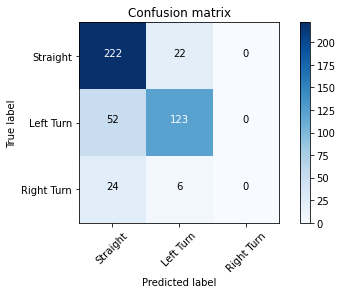

In [ ]:
# epoch = 128
epoch = 25
batch = 1

model = Sequential()
make_model_extraExtraDense_extraDropout(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

In [ ]:
epoch = 128
batch = 2

model = Sequential()
make_model_extraExtraDense_extraDropout(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

- removed last two 0.1 dropout layers
- not as good

In [ ]:
epoch = 128
batch = 8

model2 = Sequential()
make_model_extraExtraDense_extraDropout(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model2, X_test, y_test)

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       177
           1       0.73      0.75      0.74       127
           2       0.00      0.00      0.00        18

    accuracy                           0.75       322
   macro avg       0.50      0.52      0.51       322
weighted avg       0.70      0.75      0.72       322

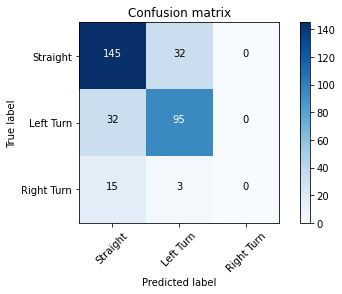

In [ ]:
epoch = 128
batch = 8

model = Sequential()
make_model_extraExtraDense_extraDropout(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

- re-added drop layers, took away one dense layer

In [ ]:
epoch = 128
batch = 8

model = Sequential()
make_model_extraExtraDense_extraDropout(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

history_conv = train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

# Round 12
- downsizing

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       244
           1       0.79      0.72      0.75       175
           2       0.00      0.00      0.00        30

    accuracy                           0.76       449
   macro avg       0.51      0.54      0.52       449
weighted avg       0.72      0.76      0.74       449
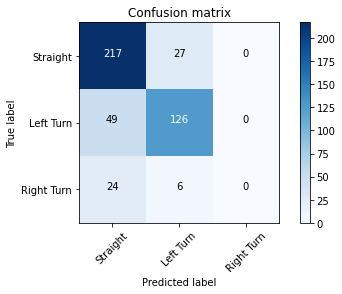

- Additional data:
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       348
           1       0.84      0.76      0.80       249
           2       0.00      0.00      0.00        36

    accuracy                           0.80       633
   macro avg       0.54      0.56      0.54       633
weighted avg       0.76      0.80      0.77       633

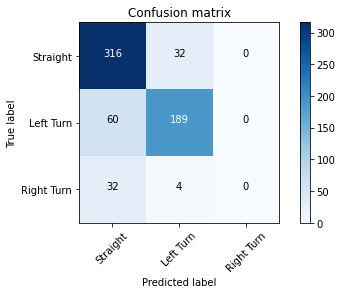

In [ ]:
# epoch = 128
epoch = 25
batch = 2

model = Sequential()
make_marikondo_model(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

# Round 13: back to square 1
- simpler model with no extra dropouts works just as well

- With dropout before dense layers
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       373
           1       0.86      0.72      0.78       249
           2       0.00      0.00      0.00        36

    accuracy                           0.80       658
   macro avg       0.54      0.55      0.54       658
weighted avg       0.76      0.80      0.77       658

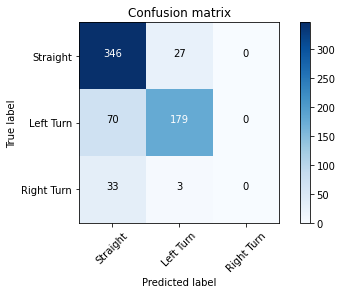

# THE WINNER

In [ ]:
- reduced images to most recent
- 84 and 82% accuracy

In [ ]:
epoch = 50
batch = 3

model = Sequential()
make_model_extraDense_lessConv(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

In [ ]:
epoch = 50
batch = 3

model = Sequential()
make_model_extraDense_lessConv(model, X_train)
reset_weights(model)
# compile
LEARNING_RATE = 1e-5
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
            metrics=['accuracy'])

train(model, X_train, y_train, batch, epoch)
model_summary(model, X_test, y_test)

# What I learned today
- add 0.1 dropout after conv layers (except last one) is good
- fewer epochs and tiny batches (1 or 2) works well
- model predictions way too slow in simulation -- how can I minimize that?


# Questions
- why do you need so many units for the second last dense layer?
- loss is TERRIBLE
- not predicting right turns at all... can't really generate data to do it though...
- in simulation there is a huge delay between having the model predict, and when the prediction gets to the robot - how to fix? less complex model?

#Save model

In [ ]:
#save the model here
#we'll have to download from drive to our local
model.save('/content/drive/MyDrive/test_data_enph353/comp_day_test_model.h5')
model_path = 'comp_day_test_model.h5'
model.save(model_path)